# [실습] 다양한 회귀 분석 모델을 활용한 분석

## 1. House price 데이터를 활용한 회귀분석
House price 데이터는 kaggle에서 확인해볼 수 있는 집값예측 데이터입니다.


### 1-1. 데이터 소개




https://www.kaggle.com/c/2019-2nd-ml-month-with-kakr


### 1-2. Evaluation, 점수 평가 기준


**RMSE** (Root Mean Squared Error)

$ \sqrt{ {1 \over n}  {\sum (y_t - y_{pr})^2} } $

- MSE에 루트를 씌운 값  
- **RMSE를 사용하면 오류 지표를 실제 값과 유사한 단위로 다시 변환하여 해석을 쉽게 한다.**  
- MAE(Mean Absolute Error)보다 상대적으로 **특이값에 Robust**하다.  
- 예측 대상의 크기에 영향을 바로 받는다.  
- **사이킷런은 RMSE를 제공하지 않으므로 MSE에 제곱근을 씌워서 계산하는 함수를 직접 만들어야 한다.**  
  

이번 실습에서 다루는 문제는 '집 값'을 예측하는 문제이기 때문에 우리가 예측해야 하는 값과 실제 정답 Label 값이 모두 실숫값입니다.    

### 1-3. Data Description, 데이터 설명


**Dataset Description**
  
[File descriptions]
- train.csv - 예측 모델을 만들기 위해 사용하는 학습 데이터입니다. 집의 정보와 예측할 변수인 가격(Price) 변수를 가지고 있습니다.
- test.csv - 학습셋으로 만든 모델을 가지고 예측할 가격(Price) 변수를 제외한 집의 정보가 담긴 테스트 데이터 입니다.
- sample_submission.csv - 제출시 사용할 수 있는 예시 submission.csv 파일입니다.

[Data fields]
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 집의 가격(Target variable)
4. bedrooms : 침실의 수
5. bathrooms : 화장실의 수
6. sqft_living : 주거 공간의 평방 피트(면적)
7. sqft_lot : 부지의 평방 피트(면적)
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트(면적)
14. sqft_basement : 지하실의 평방 피트(면적)
15. yr_built : 지어진 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)

## 2. House price 데이터를 활용한 회귀분석


**[실습 목표]**  
- 다양한 머신러닝 모델을 활용한 회귀 실습
- 평가지표를 통한 학습결과 평과 과정 이해

### 2-1. 필요 라이브러리 import

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
pd.options.display.float_format = '{:.2f}'.format
import numpy as np

import missingno as msno # 결측치 파악

# 시각화
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sns

from sklearn.model_selection import train_test_split

# 다양한 머신러닝 모델
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

# metric
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

### 2-2. 데이터 이해하기
데이터의 경로를 지정해주고, 데이터의 차원을 출력합니다.

In [ ]:
data_dir = 'data'

train_data_path = join(data_dir, 'train.csv')
sub_data_path = join(data_dir, 'test.csv')      # 테스트, 즉 submission 시 사용할 데이터 경로
print(train_data_path)
print(sub_data_path)

train = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)
print('train data dim : {}'.format(train.shape))
print('sub data dim : {}'.format(sub.shape))

#### [TODO] 불러온 데이터를 출력해봅시다.

In [ ]:
# train dataset 출력
____

In [ ]:
# sub(test dataset) 출력
____

`price` 컬럼은 정답 레이블로서 y라는 변수에 저장한 후 해당 컬럼은 지워줍니다.

In [ ]:
# train에서 y label을 따로 분리
y = train['price']
del train['price']

print(train.columns)

모델을 학습시키기 전에, 전체 데이터에 대해 탐색해보기 위해 두 데이터를 `pd.concat`으로 합쳐봅니다.

물론, 모델 학습을 진행할 때에는 다시 분리해서 사용해야 하기 때문에 데이터를 합치기 전 `train_len`에 training data의 개수를 저장해서 추후에 학습데이터만 불러올 수 있는 인덱스로 사용합니다.

In [ ]:
# 전체 데이터에 대해 탐색해보기 위하여 data에 sub를 concat 시켜봅시다. (단, 모델 학습 시에는 다시 분리해야 하므로 train_len에 training data의 갯수를 저장하여 인덱스로 활용합시다.)
train_len = len(train)
data = pd.concat((train, sub), axis=0)

print(len(data))

In [ ]:
# train과 sub가 합쳐진 데이터, data를 출력
data.head()

#### [TODO] 데이터셋의 정보를 파악해봅시다.

In [ ]:
# info 메소드를 활용하여 dataset의 정보를 파악해보자.
data._____

### 2-3. 결측치 확인하기
결측치, 즉 빈 데이터가 있는지는 위에서 설치했던 `missingno 라이브러리`를 사용해서 확인합니다.  
(NaN과 같은 결측치가 있다면 해당 부분이 하얗게 나올 것이고, 결측치가 없다면 매트릭스 전체가 까맣게 나옵니다)

#### [TODO] 결측치 데이터를 확인해봅시다.

In [ ]:
# data라는 DataFrame을 매트릭스 모양 그대로 시각화한 것
msno.matrix(data)

In [ ]:
# 1. id 컬럼이 결측치인지 확인합니다.
null_check = pd.isnull(________)
print(null_check)

In [ ]:
# 2. 결측치인 데이터만 뽑아냅니다.
null_data = data.loc[________, 'id']
null_data.head()

In [ ]:
# 3. 결측치인 데이터의 개수를 셉니다. values 메소드를 활용하시기 바랍니다.
print(f'id: {len(________.______)}')

In [ ]:
# 4. 컬럼 별로 결측치가 있는지 확인합니다. (반복문 활용)
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

### 2-4. 데이터 전처리


필요 없는 `id` 컬럼을 제거합니다. 나중에 예측 결과를 제출할 때를 대비하여 `sub_id` 변수에 `id` 칼럼을 저장해두고 지우도록 하겠습니다.

In [ ]:
# 불필요한 id 컬럼 제거 / sub_id라는 변수에 따로 저장해 둘 것
sub_id = data['id'][train_len:]
del data['id']

print(data.columns)

#### [TODO] date 컬럼을 수정해봅시다.

`date` 컬럼은 `apply` 함수로 필요한 부분만 잘라줍니다.

In [ ]:
# date 컬럼을 연/월만 표기되도록 수정하고, 데이터타입을 int형으로 바꿔줍니다.
# ex. date : 201410 형태로 출력 / to_numeric 메소드를 활용하시기 바랍니다.
data['date'] = data['date'].apply(lambda x : str(x[:6])) # 20141013T000000 형식의 데이터를 연/월 데이터만 사용하기 위해 앞에서부터 6자리만 사용
data['date'] = pd.__________(data['date']) # date 컬럼의 데이터형식을 object에서 int로 변환

data.head()

- 각 변수들의 분포 확인  

sns.kdeplot을 사용하여 너무 치우친 분포를 가지는 컬럼은 있는지 확인하고, 정규화를 시켜줍니다.

In [ ]:
# id 변수(count==0인 경우)는 제외하고 데이터의 분포를 시각화합니다.
fig, ax = plt.subplots(9, 2, figsize=(12, 50))   # 가로 스크롤 때문에 그래프 확인이 불편하시다면, figsize의 x값을 조절하는 방법도 있습니다.

count = 1
columns = data.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data=data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break

`bedrooms`, `sqft_living`, `sqft_lot`, `sqft_above`, `sqft_basement`, `sqft_living15`, `sqft_lot15` 변수가 한쪽으로 치우친 경향을 보이는데, 이렇게 한 쪽으로 치우친 분포의 경우에는 **로그 변환(log-scaling)** 을 통해 데이터 분포를 정규분포에 가깝게 만들 수 있습니다.

- np.log1p()를 활용하여 로그 변환 시켜주기  

`numpy.log1p()` 함수는 입력 배열의 각 요소에 대해 자연로그 log(1 + x)을 반환해 주는 함수입니다.

In [ ]:
# 'bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15' 컬럼들에 대해 로그 변환을 시켜줍시다.
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

변환시킨 후 데이터의 분포를 다시 확인해보면?

In [ ]:
# 변환한 컬럼들('bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15')의 데이터 분포를 다시 시각화하여 확인해봅니다.
fig, ax = plt.subplots(4, 2, figsize=(12, 24))

count = 0
for row in range(4):
    for col in range(2):
        if count == 7:
            break
        sns.kdeplot(data=data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1

log 변환을 한 후에 그래프의 분포를 보면, 변환 전과 비교했을 때 정규분포에 더 가까운 형태로 출력됩니다.
  
데이터의 분포가 한쪽으로 쏠려서 편향을 가지게 되면 모델 학습에 좋지 않은 영향을 미칠 수 있기 때문에 분석 전 데이터 시각화 및 EDA 작업을 통해서 모델 학습을 준비하는 과정이 반드시 필요합니다!
  
  
다음으로 우리가 맞춰야 할 정답 Lable, 집의 가격(`data[price]`)의 분포를 확인해봅시다.

In [ ]:
# 정답 레이블 y의 분포를 시각화해봅시다.
sns.kdeplot(y)
plt.show()

In [ ]:
# y의 데이터 역시 로그 변환 시켜줍시다.
y_log_transformation = np.log1p(y)

sns.kdeplot(y_log_transformation)
plt.show()

### 2-5. 머신러닝 모델 설계

오늘 실습에서 활용해 볼 머신러닝 모델은 다음과 같습니다.  
(in scikit-learn)
- Linear Regression  
- Logistic Regression  
- SGD Regressor  
- GradientBoostingRegressor  
- Random Forest

(not scikit-learn)
- XGBRegressor  
- LGBMRegressor


#### [TODO] scikit-learn에서 제공해주는 머신러닝 모델들을 불러옵니다.

In [ ]:
# 위의 머신러닝 모델들을 각각 불러옵니다. (scikit-learn import한 부분 참고!)

# Linear Regression
lr = ________________________

# Logistic Regression
logr = ________________________

# SGD Regressor
sgd = ________________________

# GradientBoosting Regressor
gboost = ________________________

# XGBRegressor
xgboost = ________________________

# LGBMRegressor
lgbm = ________________________

# Random Forest
rdforest = ________________________

In [ ]:
models = [lr, logr, sgd, gboost, xgboost, lgbm, rdforest]

### 2-6. 평가지표를 활용하여 머신러닝 모델 평가해보기

위에서 저장해두었던 `train_len`을 인덱스로 활용해서 `:train_len`까지는 학습 데이터, 즉 x에 저장하고, `train_len:` 부터는 실제로 추론을 해야 하는 테스트 데이터, 즉 `sub` 변수에 저장합니다.

In [ ]:
# 모델 학습을 위해 전체 data 파일을 x와 sub로 각각 분리합시다. (앞에 선언해두었던 train_len 변수를 활용할 것)
sub = data.iloc[train_len:, :]
x = data.iloc[:train_len, :]

print(x.shape)
print(sub.shape)

평가지표로는 RMSE를 활용합니다.

MSE = $ \sum {(y - \hat{y})^2} \over n $  

RMSE = $ \sqrt {\sum {(y - \hat{y})^2} \over n } $  

#### [TODO] RMSE를 직접 정의해봅니다.

In [ ]:
# 사이킷런에서 import한 mse를 활용하여 rmse 평가지표를 직접 정의해봅시다. (위의 MSE와 RMSE 식 참고)
def root_meam_squared_error(y_test, y_pred):
    return ______________________________________________

In [ ]:
df = pd.DataFrame({'LinearRegression':'-', 'LogisticRegression':'-', 'SGDRegressor':'-', 'GradientBoostingRegressor':'-', \
                   'XGBRegressor':'-', 'LGBMRegressor':'-', 'RandomForestRegressor':'-'}, index=['MAE', 'MSE', 'R_Squared', 'RMSE'])
df

#### [TODO] 모델 학습 파이프라인을 구축해봅시다.

In [ ]:
# models 변수에는 우리가 학습시키고 싶은 모델들이 들어가 있습니다. 반복문을 통해 각각 학습시키고, 평가지표(mae, mse, r_squared)를 바로 위에 선언한 df 표에 정리해봅시다.
for model in models: # models = [lr, logr, sgd, gboost, xgboost, lgbm, rdforest]
    # 모델 이름 획득
    model_name = model.__class__.__name__

    # train, test 분리하기 : train_test_split을 활용합니다, 테스트셋의 비율은 20%로 설정합니다.
    X_train, X_test, Y_train, Y_test = _______________(x, y, test_size=0.2, random_state=2023)

    # 모델 학습 : fit 메소드를 활용합니다.
    print("1st Training.. ", model_name)
    model.___(______, ______)

    # 예측 : predict 메소드를 활용합니다.
    Y_pred = model._______(______)

    # 평가지표에 기록
    df.loc['MAE', [model_name]] = mean_absolute_error(Y_test, Y_pred) # mae
    print(model_name, " mae :", mean_absolute_error(Y_test, Y_pred))
    df.loc['MSE', [model_name]] = mean_squared_error(Y_test, Y_pred) # mse
    print(model_name, " mse :", mean_squared_error(Y_test, Y_pred))
    df.loc['R_Squared', [model_name]] = r2_score(Y_test, Y_pred) # R-Squared
    print(model_name, " r_square :", r2_score(Y_test, Y_pred))

    print("------------------------------------------------------")


In [ ]:
# models 변수에는 우리가 학습시키고 싶은 모델들이 들어가 있습니다. 반복문을 통해 각각 학습시키고, 나머지 평가지표(rmse) 역시 df 표에 정리해봅시다.
for model in models: # models = [lr, logr, sgd, gboost, xgboost, lgbm, rdforest]
    if model == logr: # 로지스틱 회귀의 label은 정수형이어야 함 - log 변환으로 현재 y label의 자료형은 float!
        continue
    elif model == sgd: # sgd ValueError: Input contains infinity or a value too large for dtype('float64').
        continue

    # 모델 이름 획득
    model_name = model.__class__.__name__
    # print(model_name)

    # rmse를 위한 y_log_transformation
    x_train, x_test, y_train, y_test = train_test_split(x, y_log_transformation, test_size=0.2, random_state=2023) #, shuffle=False

    # 모델 학습
    print("2nd Training for rmse... ", model_name)
    model.fit(x_train, y_train)

    # 예측
    y_pred = model.predict(x_test)

    # 평가지표에 기록
    df.loc['RMSE', [model_name]] = root_meam_squared_error(y_test, y_pred) # rmse
    print(model_name, " rmse :", root_meam_squared_error(y_test, y_pred))

    print("-----------------------------------------------------------------")


In [ ]:
df

머신러닝 모델의 평가지표 결과를 다음 표에서 확인할 수 있습니다.   
이상탐지를 하기 위해서는 이렇게 회귀 분석만 해서는 조금 부족합니다. 이상이 있다, 그렇지 않다, 분류문제역시 해결해야하기 때문인데, 이후과정에서 한번 같이 살펴보도록 하겠습니다.

## 3. [실습] Nasa Bearings Dataset을 활용한 회귀분석

### 3-1. 데이터 소개


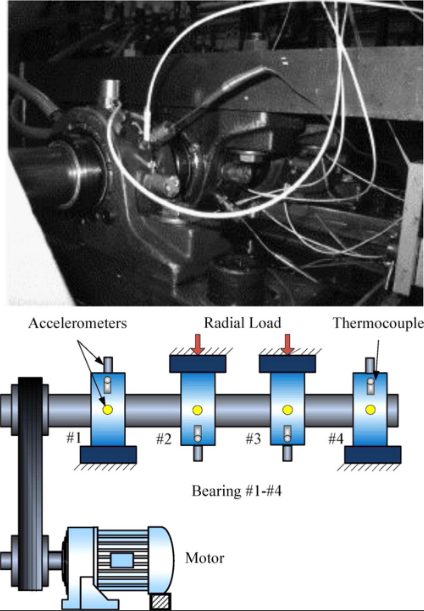

- 4개의 베어링이 축에 설치되어 있고, 마찰 벨트를 통해 축에 연결된 회전속도는 AC 모터에 의해 2000RPM으로 일정하게 유지됨  

- 스프링 메커니즘을 통해 축과 베어링에 6000 파운드의 방사하중이 가해짐

- 데이터셋1의 경우 각 베어링에 대해 두 개의 가속도계가 설치 (x축, y축)  
  (데이터셋2와 3의 경우 각 베어링에 대해 한 개의 가속도계 설치)

### 3-2. 알고리즘 동작 원리

알고리즘 동작 원리는 다음과 같습니다.

1. 원시 데이터를 가져와 몇 가지 특성(Max Value, Standard Deviation, Frequency Bands 등)을 추출합니다.

2. 머신 러닝 모델을 학습시켜 다음 시간 단계에서 이러한 특성들을 예측하도록 합니다.

3. 실제 값과 예측 값 사이의 오차를 계산합니다.

4. 제곱 오차가 훈련 세트의 오차의 표준 편차에 특정한 요소를 곱한 것보다 크다면, 첫 번째 수준의 경보를 발생시킵니다.

5. 일정 시간 윈도우 내에서 발생한 첫 번째 수준 경보의 백분율을 측정합니다. 해당 백분율이 특정 임계값을 초과한다면, 두 번째 수준의 경보를 발생시킵니다.

6. 두 번째 수준 경보가 발생한다면 기계는 고장이나 곧 고장날 가능성이 있으므로 유지보수가 필요합니다.

위와 같은 알고리즘은 주로 이상 탐지에 사용되며, 주어진 데이터에서 예측된 특성과 실제 값 간의 오차를 계산하여 시스템의 이상 여부를 판단합니다.
  
머신러닝 모델을 사용하여 훈련 데이터에서 이러한 특성을 학습하고, 오차의 크기를 통해 경보 수준을 결정하게 됩니다.  

이상 탐지 알고리즘을 통해 기계의 고장을 사전에 예측하고 유지보수가 필요한 시점을 파악할 수 있습니다.

## 4. NASA Bearing 데이터를 활용한 분석

**[실습 목표]**
- 다양한 머신러닝 모델을 활용한 건설기계 수명 예측 실습
- 다양한 평가지표를 활용한 학습결과 평가 과정 이해
  
우리가 머신러닝을 학습시키기 위해서는 학습 레이블이 필요합니다.  

다만, 현재 NASA Bearing Dataset은 베어링 관측치만 존재하기에 커스터마이징한 정답 label이 필요합니다.  

그래서 저희는 시점을 기준으로 추후 Health Status라는 label을 따로 추가하여 분류 모델을 활용해 실습을 진행합니다. (회귀 모델과 동작 파이프라인은 유사합니다)
  

### 4-1. 필요 라이브러리 import

In [ ]:
import os
import pandas as pd
pd.options.display.max_columns = None
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

from scipy.stats import entropy
from sklearn.decomposition import PCA
from scipy.optimize import curve_fit

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import xgboost as xgb
import catboost as cb
import lightgbm as lgbm
from sklearn.metrics import accuracy_score,f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis


### 4-2. 데이터셋 불러오기

In [ ]:
# - 1st Set
dataset_path_1st = './data/1st_test/1st_test/'
# - 2nd Set
dataset_path_2nd = './data/2nd_test/2nd_test/'
# - 3rd Set
dataset_path_3rd = './data/3rd_test/3rd_test/'

In [ ]:
# Test for the first file
dataset = pd.read_csv(f'{dataset_path_1st}2003.10.22.12.06.24', sep='\t')
ax = dataset.plot(figsize = (24,6), title= "Bearing Vibration" , legend = True)
ax.set(xlabel="cycle(n)", ylabel="vibration/acceleration(g)")
plt.show()

### 4-3. 데이터 전처리하기

해당 데이터는 베어링의 진동을 그대로 기록한 데이터이기 때문에, 그냥 사용할시, 그 의미를 파악하기 어렵습니다. 데이터로부터 특징을 추출하기 위한 다양한 함수를 설계합니다.

#### [TODO] RMS
* calculate_rms 함수는 DataFrame의 각 열에 대해 Root Mean Squared(RMS)를 계산합니다.
* 각 열의 값들을 제곱하고, 그 합을 구한 후 열의 길이로 나눕니다. 그 결과의 제곱근을 구하여 RMS를 계산합니다.
* 계산된 각 열의 RMS 값들을 리스트로 반환합니다.

In [ ]:
def calculate_rms(df):
    result = []
    for col in df:
        r = ________________________________________
        result.append(r)
    return result

#### [TODO] P2P
* calculate_p2p 함수는 DataFrame의 각 열에 대해 Peak-to-Peak(P2P) 값을 계산합니다.
* 각 열의 최대값과 최소값의 절대값을 각각 계산한 후 더합니다.
* 계산된 각 열의 P2P 값들을 numpy 배열로 반환합니다.

In [ ]:
def calculate_p2p(df):
    return np.array(________________________________)

#### [TODO] Shannon entropy
* calculate_entropy 함수는 DataFrame의 각 열에 대해 샤넌 엔트로피를 계산하는 데 사용됩니다.
* 각 열을 500개의 구간으로 나누고, 각 구간에 속하는 값들의 개수를 기반으로 엔트로피를 계산합니다.
* 이 함수는 데이터의 복잡성 또는 불확실성을 측정하는 샤넌 엔트로피를 계산하는 데 사용될 수 있으며, 이는 정보 이론, 데이터 압축, 기계 학습 등 다양한 분야에서 중요한 개념입니다.

In [ ]:
def calculate_entropy(df):
    ent = []
    for col in df:
        ent.append(entropy(pd.cut(____, __).value_counts()))
    return np.array(ent)

#### [TODO] Clearance Factor 계산

* calculate_clearence 함수는 주어진 DataFrame의 각 열에 대해 Clearance Factor를 계산하는 데 사용됩니다.
* 각 열의 값들의 절대값의 제곱근을 구하고, 이를 모두 합친 후 열의 길이로 나눕니다. 그리고 이 결과를 제곱하여 Clearance Factor를 계산합니다.
* Clearance Factor는 기계 진동 분석에서 특히 유용하며, 기계의 오차나 결함을 탐지하는데 사용되는 지표입니다. 이는 베어링의 결함 등을 탐지하는데 특히 유용하며, 기계의 상태 모니터링 및 진단에 사용됩니다.

In [ ]:
def calculate_clearence(df):
    result = []
    for col in df:
        r = ___________________________________________
        result.append(r)
    return result

### 4-4 Time Feature 추출

* time_features 함수는 주어진 데이터셋 경로에서 파일을 읽어들여 시간 영역 특성을 계산하고 이를 정리된 DataFrame으로 반환하는 역할을 합니다. 계산되는 특성들은 평균, 표준편차, 왜도, 첨도, 엔트로피, RMS, 최대값, 그리고 위에서 계산한 Peak-to-Peak, crest factor, clearance factor, shape factor, 그리고 impulse factor입니다.
* 함수는 먼저 데이터셋의 각 파일에서 raw 데이터를 읽어들인 후, 각각의 특성을 계산합니다. 그 후, 각 계산 결과를 별도의 DataFrame으로 만들고 이를 모두 결합(concat)합니다.
* 이 함수는 두 가지 버전의 열 세트(cols1과 cols2)를 다룰 수 있도록 설계되어 있으며, id_set 매개변수를 통해 원하는 열 세트를 선택할 수 있습니다.
* 최종적으로, 모든 데이터 파일에 대한 시간 영역 특성이 포함된 DataFrame이 반환됩니다. 이 DataFrame의 인덱스는 시간으로 설정되며, 시간 순으로 정렬됩니다. 이 함수는 시계열 데이터 분석, 신호 처리, 기계 학습 등 다양한 분야에서 데이터 전처리를 위해 사용될 수 있습니다.

In [ ]:
def time_features(dataset_path, id_set=None):
    from tqdm import tqdm
    time_features = ['mean','std','skew','kurtosis','entropy','rms','max','p2p', 'crest', 'clearence', 'shape', 'impulse']
    cols1 = ['B1_x','B1_y','B2_x','B2_y','B3_x','B3_y','B4_x','B4_y']
    cols2 = ['B1','B2','B3','B4']

    # initialize
    if id_set == 1:
        columns = [c+'_'+tf for c in cols1 for tf in time_features]
        data = pd.DataFrame(columns=columns)
    else:
        columns = [c+'_'+tf for c in cols2 for tf in time_features]
        data = pd.DataFrame(columns=columns)


    for filename in tqdm(os.listdir(dataset_path)):
        # read dataset
        raw_data = pd.read_csv(os.path.join(dataset_path, filename), sep='\t')

        # time features
        mean_abs = np.array(raw_data.abs().mean())
        std = np.array(raw_data.std())
        skew = np.array(raw_data.skew())
        kurtosis = np.array(raw_data.kurtosis())
        entropy = calculate_entropy(raw_data)
        rms = np.array(calculate_rms(raw_data))
        max_abs = np.array(raw_data.abs().max())
        p2p = calculate_p2p(raw_data)
        crest = max_abs/rms
        clearence = np.array(calculate_clearence(raw_data))
        shape = rms / mean_abs
        impulse = max_abs / mean_abs

        if id_set == 1:
            mean_abs = pd.DataFrame(mean_abs.reshape(1,8), columns=[c+'_mean' for c in cols1])
            std = pd.DataFrame(std.reshape(1,8), columns=[c+'_std' for c in cols1])
            skew = pd.DataFrame(skew.reshape(1,8), columns=[c+'_skew' for c in cols1])
            kurtosis = pd.DataFrame(kurtosis.reshape(1,8), columns=[c+'_kurtosis' for c in cols1])
            entropy = pd.DataFrame(entropy.reshape(1,8), columns=[c+'_entropy' for c in cols1])
            rms = pd.DataFrame(rms.reshape(1,8), columns=[c+'_rms' for c in cols1])
            max_abs = pd.DataFrame(max_abs.reshape(1,8), columns=[c+'_max' for c in cols1])
            p2p = pd.DataFrame(p2p.reshape(1,8), columns=[c+'_p2p' for c in cols1])
            crest = pd.DataFrame(crest.reshape(1,8), columns=[c+'_crest' for c in cols1])
            clearence = pd.DataFrame(clearence.reshape(1,8), columns=[c+'_clearence' for c in cols1])
            shape = pd.DataFrame(shape.reshape(1,8), columns=[c+'_shape' for c in cols1])
            impulse = pd.DataFrame(impulse.reshape(1,8), columns=[c+'_impulse' for c in cols1])

        else:
            mean_abs = pd.DataFrame(mean_abs.reshape(1,4), columns=[c+'_mean' for c in cols2])
            std = pd.DataFrame(std.reshape(1,4), columns=[c+'_std' for c in cols2])
            skew = pd.DataFrame(skew.reshape(1,4), columns=[c+'_skew' for c in cols2])
            kurtosis = pd.DataFrame(kurtosis.reshape(1,4), columns=[c+'_kurtosis' for c in cols2])
            entropy = pd.DataFrame(entropy.reshape(1,4), columns=[c+'_entropy' for c in cols2])
            rms = pd.DataFrame(rms.reshape(1,4), columns=[c+'_rms' for c in cols2])
            max_abs = pd.DataFrame(max_abs.reshape(1,4), columns=[c+'_max' for c in cols2])
            p2p = pd.DataFrame(p2p.reshape(1,4), columns=[c+'_p2p' for c in cols2])
            crest = pd.DataFrame(crest.reshape(1,4), columns=[c+'_crest' for c in cols2])
            clearence = pd.DataFrame(clearence.reshape(1,4), columns=[c+'_clearence' for c in cols2])
            shape = pd.DataFrame(shape.reshape(1,4), columns=[c+'_shape' for c in cols2])
            impulse = pd.DataFrame(impulse.reshape(1,4), columns=[c+'_impulse' for c in cols2])

        mean_abs.index = [filename]
        std.index = [filename]
        skew.index = [filename]
        kurtosis.index = [filename]
        entropy.index = [filename]
        rms.index = [filename]
        max_abs.index = [filename]
        p2p.index = [filename]
        crest.index = [filename]
        clearence.index = [filename]
        shape.index = [filename]
        impulse.index = [filename]

        # concat
        merge = pd.concat([mean_abs, std, skew, kurtosis, entropy, rms, max_abs, p2p,crest,clearence, shape, impulse], axis=1)
        data = pd.concat([data,merge],axis=0) ## use pandas.concat instead.

    if id_set == 1:
        cols = [c+'_'+tf for c in cols1 for tf in time_features]
        data = data[cols]
    else:
        cols = [c+'_'+tf for c in cols2 for tf in time_features]
        data = data[cols]

    data.index = pd.to_datetime(data.index, format='%Y.%m.%d.%H.%M.%S')
    data = data.sort_index()
    return data

In [ ]:
# 다음 실습 때도 바로 불러올 수 있도록 csv 파일로 변환합니다.
set1 = time_features(dataset_path_1st, id_set=1)
set1.to_csv('data/set1_timefeatures.csv')

데이터의 크기가 아주 크기 때문에 변환 작업이 오래 걸릴 수 있습니다. 다음 실습 때도 바로 불러올 수 있도록 변환된 csv 파일을 data 폴더 경로에 저장해둡니다.

In [ ]:
set1 = pd.read_csv("data/set1_timefeatures.csv")

In [ ]:
set1 = set1.rename(columns={'Unnamed: 0':'time'})
last_cycle = int(len(set1)) # 전체 사이클

set1

이동 평균 필터(또는 롤링 평균, 러닝 평균으로도 알려져 있음)는 시계열 데이터의 이동 가중합을 계산하는 시계열 필터입니다.
  
간단한 이동 평균, 누적 이동 평균 및 지수 이동 평균 방법이 특성 데이터에 적용되어 데이터를 부드럽게 처리합니다.

경험적으로 EMA(40)이 필터링에 가장 적합하다는 결론에 도달합니다. → 실제 데이터의 움직임을 가장 잘 반영하기 때문

In [ ]:
set1.describe()

### 4-5 시각화
 베어링마다 cycle별 "mean","std","skew","kurtosis","entropy","rms","max","p2p", "crest", "clearence", "shape", "impulse"를 시각화해봅시다.

* 각 베어링의 x와 y 데이터에 대한 특성을 개별 서브플롯에 표시합니다. 각 베어링에 대한 x-y 데이터는 같은 그래프에 겹쳐서 그려집니다.
* 시각화는 Matplotlib 라이브러리를 사용하며, 각 특성에 대해 별도의 그림(figure)를 생성합니다. 각 그림 내에는 4개의 서브플롯이 있으며, 각 서브플롯은 베어링 1부터 4까지를 나타냅니다.
* 그래프에는 베어링 번호와 특성 이름을 포함하는 타이틀과 "cycle"과 "value"라는 x, y축 레이블이 포함됩니다.
* 베어링 데이터의 시간에 따른 변화와 각 특성의 동향을 시각적으로 살펴볼 수 있습니다. 이는 패턴 분석, 이상 탐지, 시스템 진단 등의 작업에 유용할 수 있습니다.

In [ ]:
time_features_list = ["mean","std","skew","kurtosis","entropy","rms","max","p2p", "crest", "clearence", "shape", "impulse"]
bearings_xy = [["B"+str(n)+"_"+str(o)+"_" for n in range(1,5)] for o in ['x','y'] ]
for tf in time_features_list:
    fig = plt.figure()
    ax1 = fig.add_subplot(141)
    ax2 = fig.add_subplot(142)
    ax3 = fig.add_subplot(143)
    ax4 = fig.add_subplot(144)
    axes = [ax1,ax2,ax3, ax4]

    for i in range(4):
        col = bearings_xy[0][i]+tf
        set1[col].plot(figsize = (36,6), title="Bearing{} x-y_".format(i+1)+tf , legend = True, ax=axes[i])
        col = bearings_xy[1][i]+tf
        set1[col].plot(figsize = (36,6) , legend = True, ax=axes[i])
        axes[i].set(xlabel="cycle", ylabel="value")

4개의 베어링에 대해서 x축, y축에 대한 진동의 평균, 표준편차, 엔트로피의 값들을 시각화해보니, 각각의 베어링의 진폭의 경향성이 유사함을 볼 수 있습니다.

Creat factor(융기인자)나 베어링의 Clearance(틈새), 엔트로피 등의 그래프 경향성을 보니 수명주기를 러프하게나마 예측 할 수 있을 것 같기도 합니다.

실제로 머신러닝을 학습시켜서 저희가 예측한 주기와 유사하게 맞아떨어지는지 확인해보는 작업이 필요할 것 같습니다.


이제 머신러닝 학습을 위한 **'Health Status'라는 정답 레이블을 추가** 합니다.

In [ ]:
B1 ={
    "early" : ["2003-10-22 12:06:24" , "2003-10-23 09:14:13"],
    "suspect" : ["2003-10-23 09:24:13" , "2003-11-08 12:11:44"],
    "normal" : ["2003-11-08 12:21:44" , "2003-11-19 21:06:07"],
    "suspect_1" : ["2003-11-19 21:16:07" , "2003-11-24 20:47:32"],
    "imminent_failure" : ["2003-11-24 20:57:32","2003-11-25 23:39:56"]
}
B2 = {
    "early" : ["2003-10-22 12:06:24" , "2003-11-01 21:41:44"],
    "normal" : ["2003-11-01 21:51:44" , "2003-11-24 01:01:24"],
    "suspect" : ["2003-11-24 01:11:24" , "2003-11-25 10:47:32"],
    "imminient_failure" : ["2003-11-25 10:57:32" , "2003-11-25 23:39:56"]
}

B3 = {
    "early" : ["2003-10-22 12:06:24" , "2003-11-01 21:41:44"],
    "normal" : ["2003-11-01 21:51:44" , "2003-11-22 09:16:56"],
    "suspect" : ["2003-11-22 09:26:56" , "2003-11-25 10:47:32"],
    "Inner_race_failure" : ["2003-11-25 10:57:32" , "2003-11-25 23:39:56"]
}

B4 = {
    "early" : ["2003-10-22 12:06:24" , "2003-10-29 21:39:46"],
    "normal" : ["2003-10-29 21:49:46" , "2003-11-15 05:08:46"],
    "suspect" : ["2003-11-15 05:18:46" , "2003-11-18 19:12:30"],
    "Rolling_element_failure" : ["2003-11-19 09:06:09" , "2003-11-22 17:36:56"],
    "Stage_two_failure" : ["2003-11-22 17:46:56" , "2003-11-25 23:39:56"]
}

### 4-6 베어링의 상태값 추출

In [ ]:

B1_state = list()
B2_state = list()
B3_state = list()
B4_state = list()
cnt = 0

for row in set1["time"]:
    cnt += 1
    # B1
    if cnt<=151:
        B1_state.append("early")
    if 151 < cnt <=600:
        B1_state.append("suspect")
    if 600 < cnt <=1499:
        B1_state.append("normal")
    if 1499 < cnt <=2098:
        B1_state.append("suspect")
    if 2098 < cnt <= 2156:
        B1_state.append("imminent_failure")

    #B2
    if cnt<=500:
        B2_state.append("early")
    if 500 < cnt <=2000:
        B2_state.append("normal")
    if 2000 < cnt <=2120:
        B2_state.append("suspect")
    if 2120< cnt <=2156:
        B2_state.append("imminet_failure")

    #B3
    if cnt<=500:
        B3_state.append("early")
    if 500 < cnt <= 1790:
        B3_state.append("normal")
    if 1790 < cnt <=2120:
        B3_state.append("suspect")
    if 2120 < cnt <=2156:
        B3_state.append("Inner_race_failure")

    #B4
    if cnt<=200:
        B4_state.append("early")
    if 200 < cnt <=1000:
        B4_state.append("normal")
    if 1000 < cnt <= 1435:
        B4_state.append("suspect")
    if 1435 < cnt <=1840:
        B4_state.append("Inner_race_failure")
    if 1840 < cnt <=2156:
        B4_state.append("Stage_two_failure")

# controlling the counts
from collections import Counter
print(Counter(B1_state))
print(Counter(B2_state))
print(Counter(B3_state))
print(Counter(B4_state))

set1["B1_state"] = B1_state
set1["B2_state"] = B2_state
set1["B3_state"] = B3_state
set1["B4_state"] = B4_state

set1.head()

In [ ]:
B1_cols = [col for col in set1.columns if "B1" in col]
B2_cols = [col for col in set1.columns if "B2" in col]
B3_cols = [col for col in set1.columns if "B3" in col]
B4_cols = [col for col in set1.columns if "B4" in col]

B1 = set1[B1_cols]
B2 = set1[B2_cols]
B3 = set1[B3_cols]
B4 = set1[B4_cols]

cols = ['Bx_mean','Bx_std','Bx_skew','Bx_kurtosis','Bx_entropy','Bx_rms','Bx_max','Bx_p2p','Bx_crest', 'Bx_clearence', 'Bx_shape', 'Bx_impulse',
        'By_mean','By_std','By_skew','By_kurtosis','By_entropy','By_rms','By_max','By_p2p','By_crest', 'By_clearence', 'By_shape', 'By_impulse',
        'class']
B1.columns = cols
B2.columns = cols
B3.columns = cols
B4.columns = cols

final_data = pd.concat([B1,B2,B3,B4], axis=0, ignore_index=True)
final_data.describe()

In [ ]:
# 모델 학습에 활용할 최종 데이터를 출력해봅니다.
final_data

### 4-7 모델 학습

#### [TODO] 모델 학습을 위한 데이터셋 구성과 모델 학습을 진행해봅시다.

In [ ]:
# 모델 학습을 위한 데이터셋 구성
X = final_data.copy()
y = X.pop("class")
le = preprocessing.LabelEncoder()
le.fit(y)
y = le.transform(y)

# train_test_split을 활용한 trainset과 testset 분리
X_train, X_test, y_train, y_test = _____________(_, _, test_size = 0.3, random_state =1)

In [ ]:
# XGBoost를 활용하여 학습합니다. XGBClassifier 모델을 활용하세요.
xgb_cl = xgb.______________(use_label_encoder=False)
xgb_cl.___(X_train, y_train)

preds = xgb_cl.predict(X_test)
accuracy_score(y_test, preds)

In [ ]:
time_features_list = ["mean","std","skew","kurtosis","entropy","rms","max","p2p", "crest", "clearence", "shape", "impulse"]

x_axis_cols = ["Bx_"+tf for tf in time_features_list]
print(x_axis_cols)
X_x = X.copy()
X_x = X[x_axis_cols]
cols = ['B_mean','B_std','B_skew','B_kurtosis','B_entropy',
        'B_rms','B_max','B_p2p','B_crest', 'B_clearence', 'B_shape', 'B_impulse']
X_x.columns = cols
X_x_train, X_x_test, y_train, y_test = train_test_split(X_x, y, test_size = 0.3, random_state =1)

In [ ]:
# 다양한 모델에 학습시켜보기
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA","XGBoost","CatGBoost","LightGBoost"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
    xgb.XGBClassifier(),
    cb.CatBoostClassifier(verbose = False),
    ]

for name, clf in zip(names, classifiers):
    print("training "+name+" ...")
    clf.fit(X_x_train,y_train)
    score = clf.score(X_x_test,y_test)
    print('Score of'+name+' is: '+str(score))
    # iterate over classifiers

#### [TODO] SMA
* set1 DataFrame의 복사본인 features DataFrame에서 "B4_x_mean" 컬럼을 선택하여 새로운 DataFrame ma에 저장합니다.
* rolling(window=5).mean() 함수를 사용하여 5개의 연속된 값에 대한 평균을 계산하여 "SMA" 컬럼을 생성합니다. 이는 5일 이동 평균을 의미합니다.
* 마지막으로, features DataFrame의 'time' 컬럼을 ma DataFrame에 추가합니다.
* 베어링 4의 x방향 평균 값에 대한 5일 이동 평균을 계산하고, 그 결과를 새로운 DataFrame에 저장합니다. 이동 평균은 시계열 데이터에서 노이즈를 줄이고 경향성을 더 잘 파악하기 위한 기법으로 널리 사용됩니다.

In [ ]:
features = set1.copy()

ma = pd.DataFrame()
ma['B4_x_mean'] = features['B4_x_mean']
ma['SMA'] = ma['B4_x_mean'].rolling(________).______
ma['time'] = features['time']

In [ ]:
#Cumulative Moving Average
ma['CMA'] = ma["B4_x_mean"].expanding(min_periods=10).mean()

In [ ]:
#Exponantial Moving Average
ma['EMA'] = ma['B4_x_mean'].ewm(span=40,adjust=False).mean()

In [ ]:
ma.plot(x="time", y= ['B4_x_mean','SMA','CMA','EMA'],rot=45)

- 단순이동평균 (SMA) : 특정 기간 동안의 베어링 데이터의 값을 모두 더한 다음 해당 수치를 계산 평균의 기간 수로 나눈 산술 이동 평균 값으로 주로 주식시장에서 가장 기본적이면서도 널리 사용되는 지표 (추세와 지지 및 저항선을 파악하는데 도움)

- 누적이동평균 (CMA) : SMA와 같이 산술평균을 구하는 것은 동일하지만, window(데이터를 볼 범위) 값을 정하지 않습니다. (모든 데이터를 고려할 때 사용하며, 이전의 모든 데이터에 영향)

- 지수이동평균 (EMA) : 최근의 데이터에 더 높은 가중치를 두는 가중이동평균법
  
 => EMA(i) = k * price(i) + (1-k) * EMA(i-1)

---
4번째 베어링의 평균값들의 시간에 따른 경향성과 SMA, EMA의 값들이 유사함을 확인할 수 있습니다. 각각의 파트에서 분포가 큰 경우가 있지만, 큰 흐름에서 보면 규칙성이 존재한다고 볼 수도 있을 것 같습니다.

### 4-8 주성분 분석(PCA)  

degradation model 활용을 위해 주성분 분석(PCA)를 사용하여 기본 특성의 정보를 대표하는 특성을 추출합니다.

분산이 가장 큰 주성분을 선택하여 데이터의 차원성과 중복성을 감소시키고, 데이터에서 주요한 특성만을 얻을 수 있습니다.

- Model fitting  

시계열 예측에서는 degradation이 지수적으로 발생한다고 가정합니다.  
따라서 양의 기울기를 가지는 지수적 모델을 함수로 생성하고, scipy.optimize 라이브러리를 사용하여 최적화 시킵니다.


In [ ]:
# RUL(Remaining Useful Life) Prediction (베어링 수명 예측)
def health_indicator(bearing_data,use_filter=False):
    data = bearing_data.copy()
    if use_filter:
        for ft in data.columns:
            data[ft] = data[ft].ewm(span=40,adjust=False).mean()
    pca = PCA()
    X_pca = pca.fit_transform(data)
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    print("Explained variance of Pricincipal Component 1 is:"+str(pca.explained_variance_ratio_[0]))
    health_indicator = np.array(X_pca['PC1'])
    degredation = pd.DataFrame(health_indicator,columns=['PC1'])
    degredation['cycle'] = degredation.index
    degredation['PC1'] = degredation['PC1']-degredation['PC1'].min(axis=0)

    return degredation

def fit_exp(df,base=500,print_parameters=False):
    x =np.array(df.cycle)
    x = x[-base:].copy()
    y = np.array(df.PC1)
    y = y[-base:].copy()
    def exp_fit(x,a,b):
        y = a*np.exp(abs(b)*x)
        return y
    #initial parameters affect the result
    fit = curve_fit(exp_fit,x,y,p0=[0.01,0.001],maxfev=10000)
    if print_parameters:
        print(fit)
    return fit

def predict(X_df,p):
    x =np.array(X_df.cycle)
    a,b = p[0]
    fit_eq = a*np.exp(abs(b)*x)
    return fit_eq

log = [[],[]]

처음 550 cycle은 정상 상태로 가정합니다.

In [ ]:
prediction_cycle = 550

# 초기값 설정
init_cycle = prediction_cycle

특징중 최댓값, 고저폭, RMS값을 추출해서 확인합니다.

In [ ]:
selected_features = ['max','p2p','rms']

bearing = 3
B_x = ["B{}_x_".format(bearing)+i for i in selected_features]
early_cycles = set1[B_x][:init_cycle]
early_cycles_pca = health_indicator(early_cycles,use_filter=True)

### 4-9 시각화
* 주어진 베어링 데이터 세트(set1) 내의 특정 cycle 범위 내에서 베어링의 건강 상태 지표(health_indicator)를 계산하고, 이를 바탕으로 고장날 때까지의 cycle 수를 예측합니다.
* "health_indicator" 함수는 주어진 데이터에 대한 베어링의 건강 지표를 계산합니다. 이 지표는 베어링의 성능이 시간에 따라 어떻게 변하는지를 나타내는 중요한 측정 항목입니다.
* "fit_exp" 함수는 건강 지표에 지수 함수를 적합시키고, "predict" 함수는 적합된 함수를 사용하여 베어링의 건강 지표를 예측합니다.
* 다음 지정된 임계값(threshold)에 도달할 때까지 걸리는 예상 cycle 수를 계산합니다. 이 값은 베어링이 고장날 때까지 걸릴 것으로 예상되는 시간을 나타냅니다.

In [ ]:
# 베어링의 예측 수명을 시각화해봅니다. (처음 550 cycle은 threshold를 넘지 않는 값들로 예측이 될 것입니다.)

data = set1[B_x][:prediction_cycle]
ind=data.index
degredation = health_indicator(data,use_filter=True)
# degredation.plot(y='PC1',x='cycle')
fit = fit_exp(degredation,base=250)

prediction = predict(degredation,fit)
m,n = fit[0]
thres = 2
# print(prediction_cycle)
fail_cycle = (np.log(thres/m))/abs(n)
log[0].append(prediction_cycle)
log[1].append(fail_cycle)

print(m,n)
print('failed at'+str(fail_cycle))

fig =plt.figure('Cycle: '+str(prediction_cycle))
ax =fig.subplots()

ax.plot([0,prediction_cycle],[2,2])
ax.scatter(degredation['cycle'],degredation['PC1'],color='b',s=5)
ax.plot(degredation['cycle'],prediction,color='r',alpha=0.7)
ax.set_title('Cycle: '+str(prediction_cycle))
ax.legend(['threshold','prediction'])
fig.savefig('output.png')
plt.show()
increment_cycle =25
prediction_cycle += increment_cycle

#### [TODO] 전체 Cycle에 대해 threshold를 넘어가는 시점을 확인해봅시다.

(hint) 데이터셋 분포를 확인했을 때, 각 베어링 데이터의 관측 시점의 갯수는 2156개였습니다.

In [ ]:
# 전체 cycle에 대해서도 출력해봅시다. (특정 threshold를 넘어가는 시점을 직접 확인해봅시다)
prediction_cycle = ____

data = set1[B_x][:prediction_cycle]
ind=data.index
degredation = health_indicator(data,use_filter=True)
#degredation.plot(y='PC1',x='cycle')
fit = fit_exp(degredation,base=250)

prediction = predict(degredation,fit)
m,n = fit[0]
thres = 2
# print(prediction_cycle)
fail_cycle = (np.log(thres/m))/abs(n)
log[0].append(prediction_cycle)
log[1].append(fail_cycle)

print(m,n)
print('failed at'+str(fail_cycle))

fig =plt.figure('Cycle: '+str(prediction_cycle))
ax =fig.subplots()

ax.plot([0,prediction_cycle],[2,2])
ax.scatter(degredation['cycle'],degredation['PC1'],color='b',s=5)
ax.plot(degredation['cycle'],prediction,color='r',alpha=0.7)
ax.set_title('Cycle: '+str(prediction_cycle))
ax.legend(['threshold','prediction'])
fig.savefig('output.png')
plt.show()
increment_cycle =25
prediction_cycle += increment_cycle

<span style="color:rgb(120, 120, 120)">본 학습 자료를 포함한 사이트 내 모든 자료의 저작권은 엘리스에 있으며 외부로의 무단 복제, 배포 및 전송을 불허합니다.

Copyright @ elice all rights reserved</span>